In [440]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-price/Tesla.csv - Tesla.csv.csv


**On this note book we use  ARIMA prediction on the test set and feeding it to the LSTM model to capture non-linear trends and the residuals of ARIMA prediction123. This is a hybrid ARIMA-LSTM model If there are any errors please let us know**

In [441]:
import math
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima


In [442]:
data = pd.read_csv("../input/tesla-stock-price/Tesla.csv - Tesla.csv.csv",index_col='Date', parse_dates=True)

In [443]:
data

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...
2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996


In [444]:
# Resample the data to yearly frequency and count the number of days per year
days_per_year = data.resample('Y').count()

# Display the result
print(days_per_year)

            Open  High  Low  Close  Volume  Adj Close
Date                                                 
2010-12-31   130   130  130    130     130        130
2011-12-31   252   252  252    252     252        252
2012-12-31   250   250  250    250     250        250
2013-12-31   252   252  252    252     252        252
2014-12-31   252   252  252    252     252        252
2015-12-31   252   252  252    252     252        252
2016-12-31   252   252  252    252     252        252
2017-12-31    52    52   52     52      52         52


In [445]:
data.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


# ***we will work on closing price ***

In [446]:
close_data = data.iloc[:, 3:4]

In [447]:
close_data

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2017-03-13,246.169998
2017-03-14,258.000000
2017-03-15,255.729996


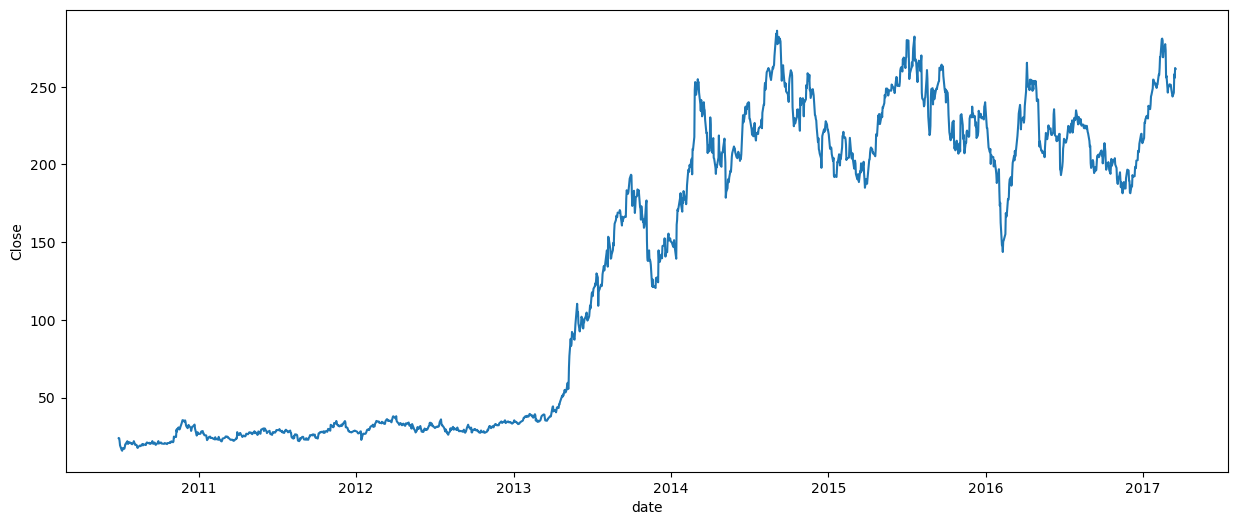

In [448]:
# Plot the data
plt.plot(close_data)
plt.xlabel('date')
plt.ylabel('Close')
plt.show()

In [449]:
# Apply the Augmented Dickey-Fuller test
result = adfuller(close_data['Close'])

# Print the test statistic and p-value
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.813733
p-value: 0.815055


p value >0.05 so we try differencing the data

# search for d (differencing)

ADF Statistic: -0.813733
p-value: 0.815055
ADF Statistic: -39.848280
p-value: 0.000000
ADF Statistic: -14.448064
p-value: 0.000000


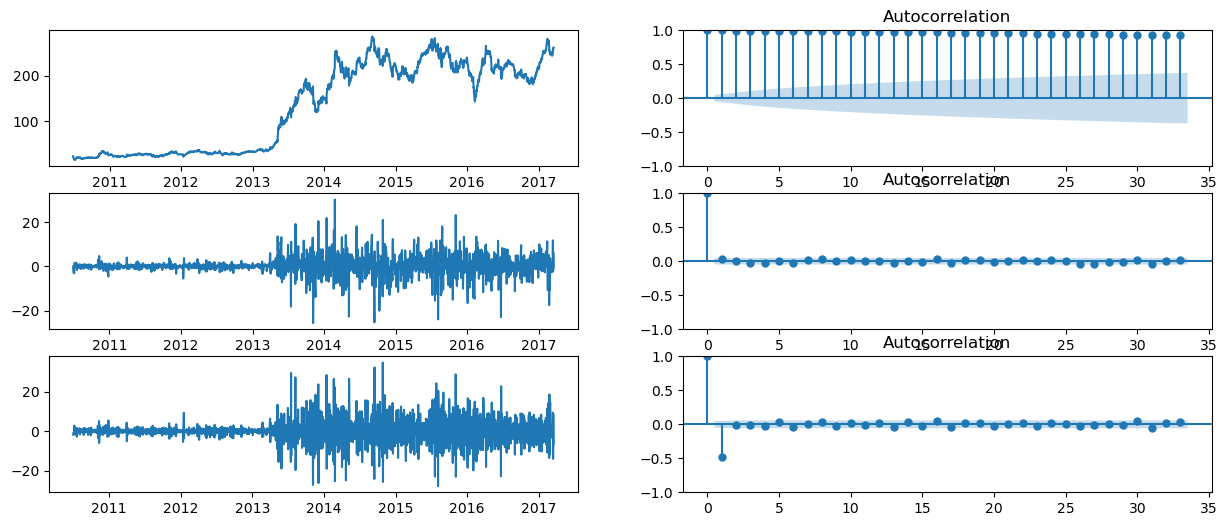

In [450]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


# Apply differencing to the data


# Create a grid of subplots
fig, axes = plt.subplots(3, 2)
 
# Plot the autocorrelation function for the differenced data three times
df=close_data
for i in range(3):
    axes[i,0].plot(df) 
    plot_acf(df['Close'], ax=axes[i,1])
    # Apply the Augmented Dickey-Fuller test
    result = adfuller(df['Close'])
    # Print the test statistic and p-value
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    df = df.diff().dropna()

plt.show()


****with difference equal to 1 the data become stationary****

# search for  p(AR)

Text(0.5, 1.0, 'Differencing at lag 1')

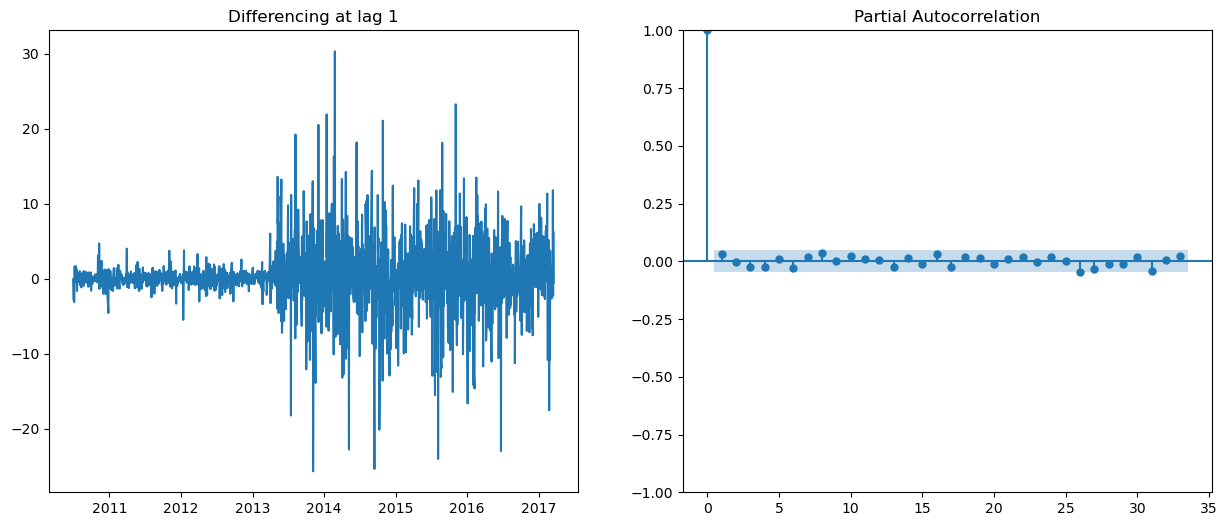

In [451]:
df=close_data
df=df.diff().dropna()
fig, axes = plt.subplots(1,2)
axes[0].plot(df)  
plot_pacf(df['Close'],ax=axes[1])
axes[0].set_title('Differencing at lag 1')

**all lags in the PACF plot fall within the confidence interval bounds**

# search for q(MA)

Text(0.5, 1.0, 'Differencing at lag 1')

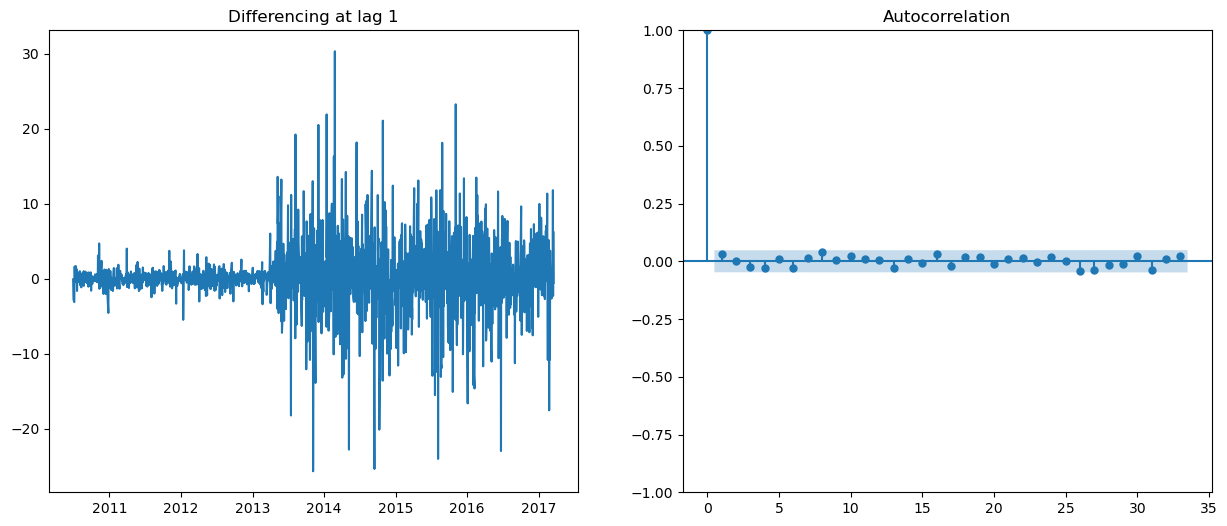

In [452]:
df=close_data
df=df.diff().dropna()
fig, axes = plt.subplots(1,2)
axes[0].plot(df)  
plot_acf(df['Close'],ax=axes[1])
axes[0].set_title('Differencing at lag 1')

In [453]:
N=60 #last N days for evaluating Arima and the hybrid(lstm+arima)

In [455]:
# prepare  dataset split it on test and train and choose 
ariama_data=close_data.iloc[:close_data.shape[0]-N,:] # Get all data except the last N days
train_size = int(len(ariama_data['Close']) * 0.7)
train, test = ariama_data['Close'][0:train_size], ariama_data['Close'][train_size:] 

# Use AIC to get the best Arima order 

In [456]:


model = auto_arima(train, start_p=0, start_q=0,
                       test='adf',       # use adftest to find optimal 'd'
                       max_p=30, max_q=30, # maximum p and q
                       m=1,              # frequency of series
                       d=None,           # let model determine 'd'
                       seasonal=False,   # No Seasonality
                       start_P=0, 
                       D=0, 
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)
   


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6329.559, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6331.554, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6331.554, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6329.514, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6333.377, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.727 seconds


In [457]:
model = ARIMA(train, order=(0, 1, 0))
arima_model = model.fit()

# test the model 

In [458]:
test_predictions  = arima_model.forecast(steps=len(test))
r2_test = r2_score(test, predictions)

In [459]:
r2_test

-0.28885633665158617

In [460]:
predictions = pd.DataFrame(test_predictions.tolist(), columns=['Close'])
predictions = predictions.set_index(test.reset_index()['Date'])

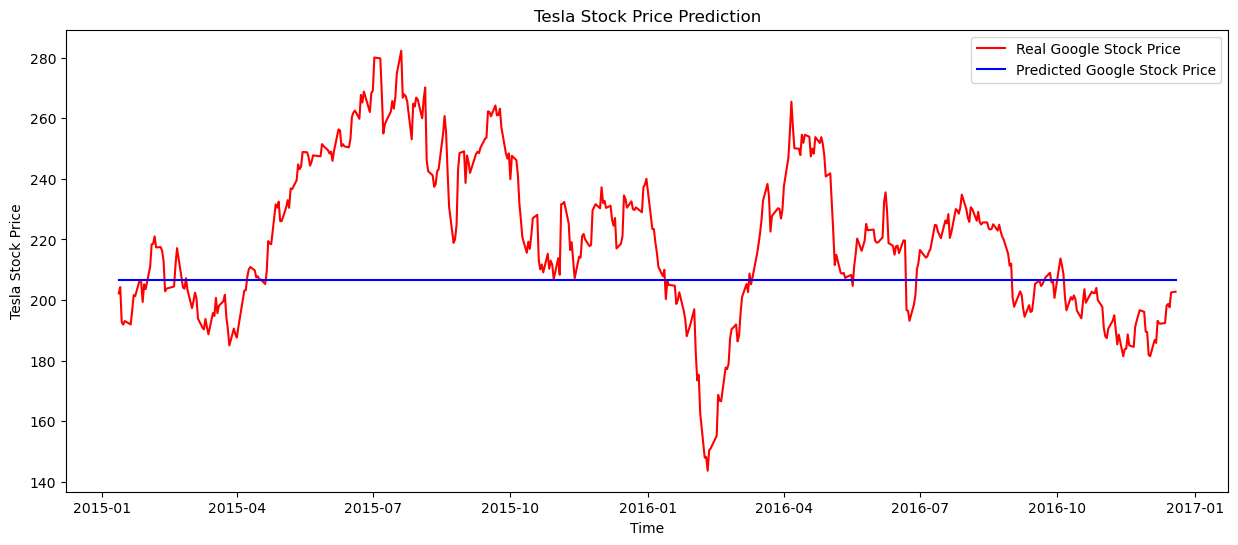

In [461]:
# Visualising the results
plt.plot(test, color = 'red', label = 'Real Google Stock Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

# ARIMA & LSTM hybrid model

In [462]:
#choose the window 
n_steps=70

In [463]:
# Prepare data for LSTM model
def prepare_data(x, y, n_steps):
    X, Y = [], []
    for i in range(len(x) - n_steps):
        seq_x = x[i:i+n_steps]
       
        seq_y = y[i+n_steps-1]
     
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)



X_train, y_train = prepare_data(test_predictions,test,n_steps)

In [464]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Define LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64))

model.add(Dense(25))
model.add(Dense(1))
model.compile( loss='mse',optimizer=Adam(clipnorm=1.0))




In [465]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=6, verbose=1,min_lr=1e-9)

In [466]:
# Fit LSTM model
model.fit(X_train, y_train, epochs=70)

Epoch 1/70
14/14 [==============================] - 5s 108ms/step - loss: 50227.4648
Epoch 2/70
14/14 [==============================] - 2s 109ms/step - loss: 50306.3867
Epoch 3/70
14/14 [==============================] - 2s 107ms/step - loss: 49868.6367
Epoch 4/70
14/14 [==============================] - 2s 109ms/step - loss: 49857.8203
Epoch 5/70
14/14 [==============================] - 2s 111ms/step - loss: 49949.5781
Epoch 6/70
14/14 [==============================] - 2s 113ms/step - loss: 49756.3242
Epoch 7/70
14/14 [==============================] - 2s 110ms/step - loss: 49397.0391
Epoch 8/70
14/14 [==============================] - 2s 107ms/step - loss: 48755.5625
Epoch 9/70
14/14 [==============================] - 2s 110ms/step - loss: 48153.7383
Epoch 10/70
14/14 [==============================] - 2s 110ms/step - loss: 47947.6953
Epoch 11/70
14/14 [==============================] - 2s 107ms/step - loss: 48480.6172
Epoch 12/70
14/14 [==============================] - 2s 119ms/s

# ARIMA predection for the next N days

In [467]:
# get the last 60 days N=60
res_set=close_data.iloc[-N:,:]

In [468]:
def arima_predict(res_set,arima_model,steps):
    predictions = list(arima_model.forecast(steps=steps))
    r2 = r2_score(res_set, predictions)
    return predictions, r2


In [469]:
next_n_predictions,next_n_r2=arima_predict(res_set,model_fit,N) #N=60

In [470]:
next_n_r2

-4.382808245045735

In [471]:
next_n_predictions = pd.DataFrame(next_n_predictions, columns=['Close'])
next_n_predictions = next_n_predictions.set_index(res_set.reset_index()['Date'])

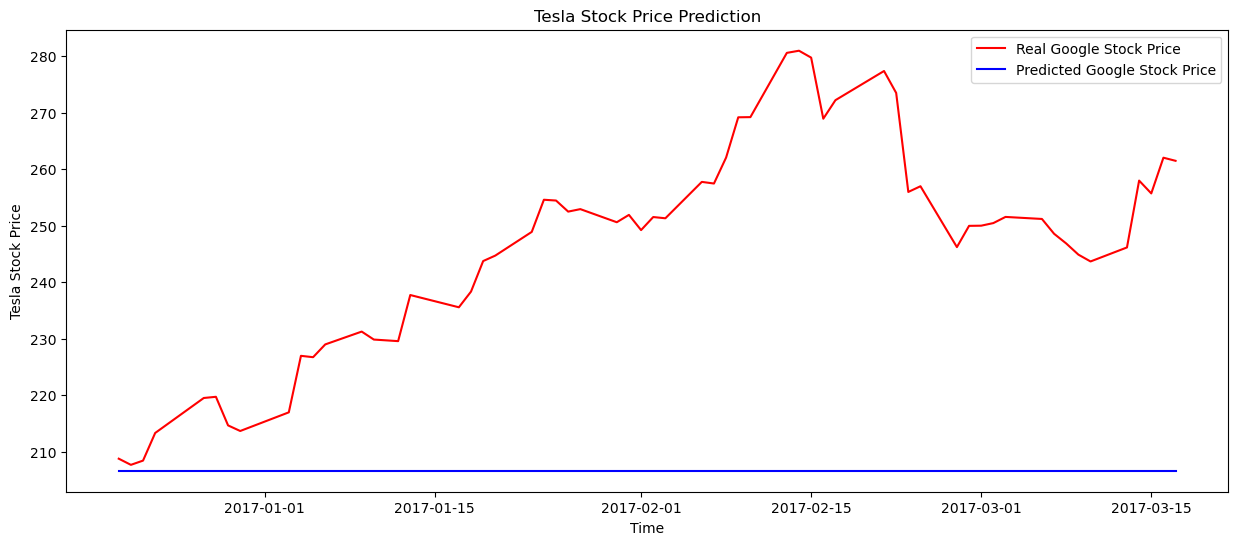

In [472]:
# Visualising the results
plt.plot(res_set, color = 'red', label = 'Real Google Stock Price')
plt.plot(next_n_predictions, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

# Hybrid(Lstm+Arima) predection for the next N days 

In [473]:

# Make predictions with LSTM model
history = test_predictions[-n_steps:]
hybrid_predictions = []
for i in range(len(next_n_predictions)):
    x_input = np.array(history[-n_steps:])
    x_input = x_input.reshape((1, n_steps, n_features)) 
    yhat = model.predict(x_input,verbose=0)[0][0]
    hybrid_predictions.append(yhat)
    history.append(pd.Series(next_n_predictions['Close'][i]))


In [474]:
r2_hybrid = r2_score(res_set, hybrid_predictions)

In [475]:
r2_hybrid

-1.5288837188637023

In [476]:
hybrid_predictions = pd.DataFrame(hybrid_predictions, columns=['Close'])


In [477]:

hybrid_predictions = hybrid_predictions.set_index(res_set.reset_index()['Date'])

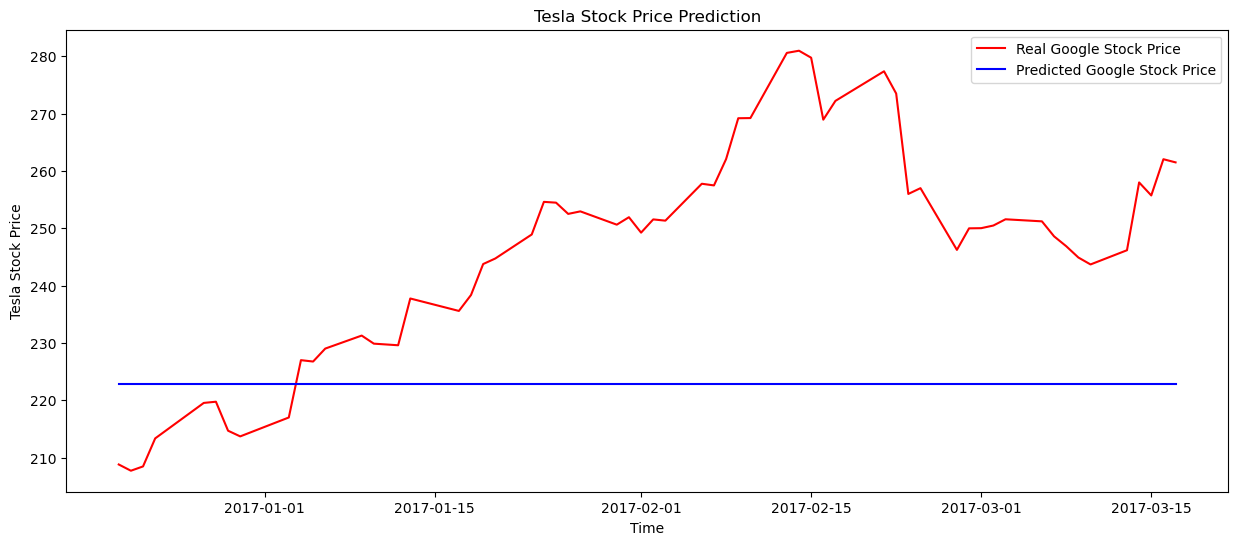

In [478]:
# Visualising the results
plt.plot(res_set, color = 'red', label = 'Real Google Stock Price')
plt.plot(hybrid_predictions, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()